# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Data-formatting,-feature-manipulation" data-toc-modified-id="Data-formatting,-feature-manipulation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data formatting, feature manipulation</a></div><div class="lev1 toc-item"><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></div><div class="lev1 toc-item"><a href="#Performance-by-location" data-toc-modified-id="Performance-by-location-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Performance by location</a></div><div class="lev2 toc-item"><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Logistic regression</a></div><div class="lev2 toc-item"><a href="#Decision-tree" data-toc-modified-id="Decision-tree-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Decision tree</a></div><div class="lev2 toc-item"><a href="#Random-forest" data-toc-modified-id="Random-forest-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random forest</a></div><div class="lev1 toc-item"><a href="#Cross-location-performance" data-toc-modified-id="Cross-location-performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cross-location performance</a></div><div class="lev2 toc-item"><a href="#Decision-tree-trained-on-SF-data" data-toc-modified-id="Decision-tree-trained-on-SF-data-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Decision tree trained on SF data</a></div><div class="lev2 toc-item"><a href="#Decision-tree-trained-on-NYC-data" data-toc-modified-id="Decision-tree-trained-on-NYC-data-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Decision tree trained on NYC data</a></div><div class="lev1 toc-item"><a href="#Train-model-on-all-available-data" data-toc-modified-id="Train-model-on-all-available-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train model on all available data</a></div><div class="lev1 toc-item"><a href="#Test-with-rtc-data" data-toc-modified-id="Test-with-rtc-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test with rtc data</a></div>

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pytz
import itertools

from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors

import pvlib

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

%load_ext autoreload
%autoreload 2

# Load data

In [2]:
!ls

2003-04-06.csv       denver_area          nsrdb_ml-Copy1.ipynb
2003-04-07.csv       dt.dot               nsrdb_ml.ipynb
abq_area             dt.png               nyc_area
bay_area             filter_mask.csv      ser_filter.csv
data.csv             la_area


In [3]:
bay_files = [os.path.join('./bay_area', i) for i in os.listdir('./bay_area') if i.endswith('csv')]
la_files = [os.path.join('./la_area', i) for i in os.listdir('./la_area') if i.endswith('csv')]
nyc_files = [os.path.join('./nyc_area', i) for i in os.listdir('./nyc_area') if i.endswith('csv')]
denver_files = [os.path.join('./denver_area', i) for i in os.listdir('./denver_area') if i.endswith('csv')]

In [4]:
bay_data = pd.concat([pd.read_csv(f, header=2) for f in bay_files])
bay_data['location'] = 'sf'
la_data = pd.concat([pd.read_csv(f, header=2) for f in la_files])
la_data['location'] = 'la'
nyc_data = pd.concat([pd.read_csv(f, header=2) for f in nyc_files])
nyc_data['location'] = 'nyc'
denver_data = pd.concat([pd.read_csv(f, header=2) for f in denver_files])
denver_data['location'] = 'denver'

# Data formatting, feature manipulation

In [5]:
def prepare_for_run(df, timezone):
    df.index = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.index = df.index.tz_localize('UTC')
    df.index = df.index.tz_convert(timezone)
    
    df['time'] = df.index 
    df['min_of_day'] = df['time'].apply(lambda x: (x.hour * 60) + (x.minute) + (x.second / 60)) # daily trends
    df['min_of_day'] = np.abs(df['min_of_day'] - 720)
    
    df['week_of_year'] = df['time'].apply(lambda x: x.week) # seasonal trends
    df['week_of_year'] = np.abs(df['week_of_year'] - 26)
    
    # df['sky_status'] = (df['Cloud Type'] == 0) & (df['GHI'] >= 200) # clear skies are encoded as 0 (from csv header)
    df['sky_status'] = (df['Cloud Type'] == 0) & (df['GHI'] >= 0) # clear skies are encoded as 0 (from csv header)
   
    df['ghi_ratio'] = (df['GHI'] / df['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)
    
    df['ghi_pct_error'] = np.abs((df['GHI'] - df['Clearsky GHI']) / df['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)
    
    df['ghi_next'] = df['GHI'].shift(-1)
    df['ghi_last'] = df['GHI'].shift(1)
    df['ghi_cs_next'] = df['Clearsky GHI'].shift(-1)
    df['ghi_cs_last'] = df['Clearsky GHI'].shift(1)
    df['ghi_last_ratio'] = (df['ghi_last'] / df['ghi_cs_last']).replace([np.inf, -np.inf, np.nan], 0)
    df['ghi_next_ratio'] = (df['ghi_next'] / df['ghi_cs_next']).replace([np.inf, -np.inf, np.nan], 0)
        
    return df

In [6]:
results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(prepare_for_run, i, j) for i, j 
               in zip([bay_data, la_data, nyc_data, denver_data], ['US/Pacific', 'US/Pacific', 'US/Eastern', 'US/Mountain'])]

In [7]:
df = pd.concat([i.result() for i in results])

In [8]:
df.keys()

Index(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'DHI',
       'DNI', 'Day', 'Dew Point', 'Fill Flag', 'GHI', 'Hour', 'Minute',
       'Month', 'Precipitable Water', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Temperature', 'Wind Direction', 'Wind Speed',
       'Year', 'ghi_cs_last', 'ghi_cs_next', 'ghi_last', 'ghi_last_ratio',
       'ghi_next', 'ghi_next_ratio', 'ghi_pct_error', 'ghi_ratio', 'location',
       'min_of_day', 'sky_status', 'time', 'week_of_year'],
      dtype='object')

In [9]:
pd.unique(df['location'])

array(['sf', 'la', 'nyc', 'denver'], dtype=object)

# Modeling

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From sklearn docs.
    """
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 4)

    fig, ax = plt.subplots(figsize=(3,3))
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(p, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    return ax


In [11]:
columns = ['GHI', 'Clearsky GHI', 'ghi_ratio', 'sky_status']

In [12]:
len(df)

1261440

# Performance by location

In [13]:
def analysis(data, clf, columns):
    X = data[columns[:-1]].values
    y = data[columns[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='f1')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.f1_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))

## Logistic regression

<IPython.core.display.Javascript object>


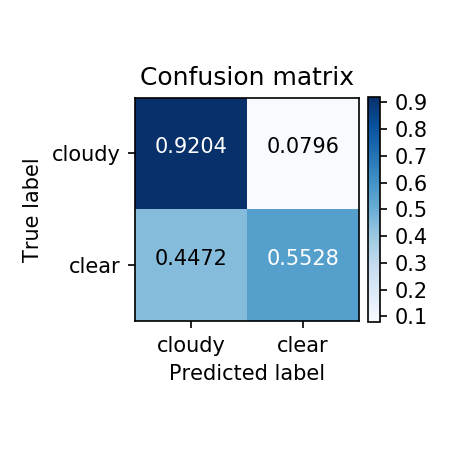

CV scoring: 0.6734 +/ -  0.0002
Test score: 0.6757888060884732


In [14]:
analysis(df[df['location'] == 'sf'], linear_model.LogisticRegression(), columns)

<IPython.core.display.Javascript object>


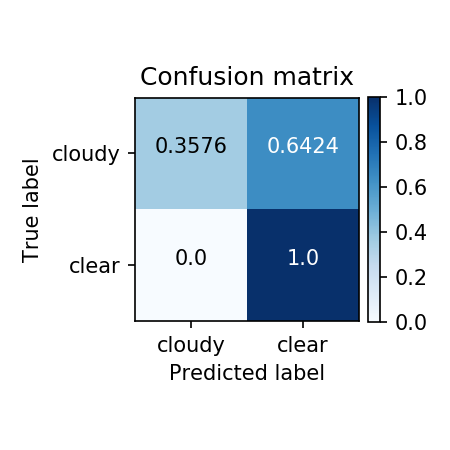

CV scoring: 0.8244 +/ -  0.0007
Test score: 0.825470961020922


In [15]:
analysis(df[df['location'] == 'la'], linear_model.LogisticRegression(), columns)

<IPython.core.display.Javascript object>


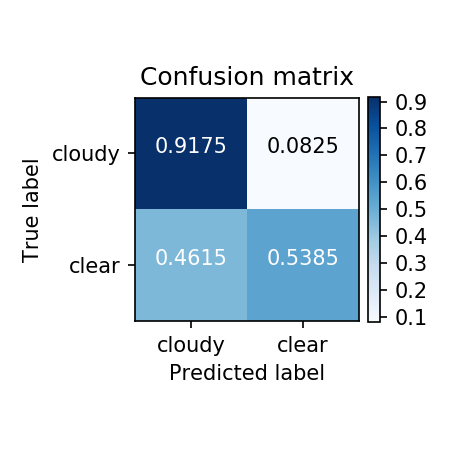

CV scoring: 0.6357 +/ -  0.001
Test score: 0.6361601377529057


In [16]:
analysis(df[df['location'] == 'denver'], linear_model.LogisticRegression(), columns)

<IPython.core.display.Javascript object>


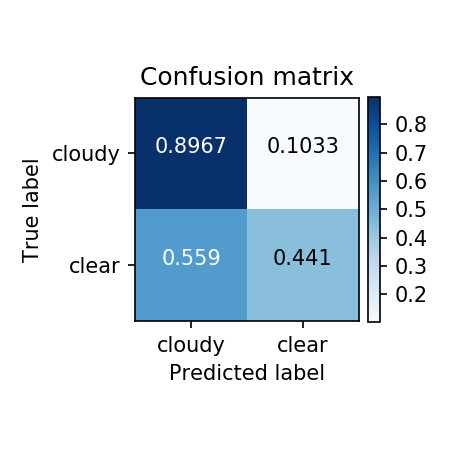

CV scoring: 0.5219 +/ -  0.0014
Test score: 0.5180098402925777


In [17]:
analysis(df[df['location'] == 'nyc'], linear_model.LogisticRegression(), columns)

## Decision tree

<IPython.core.display.Javascript object>


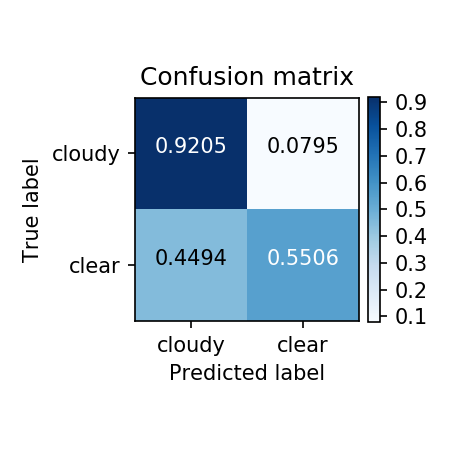

CV scoring: 0.6742 +/ -  0.0008
Test score: 0.6740180500826236


In [18]:
analysis(df[df['location'] == 'sf'], tree.DecisionTreeClassifier(max_depth=5), columns)

<IPython.core.display.Javascript object>


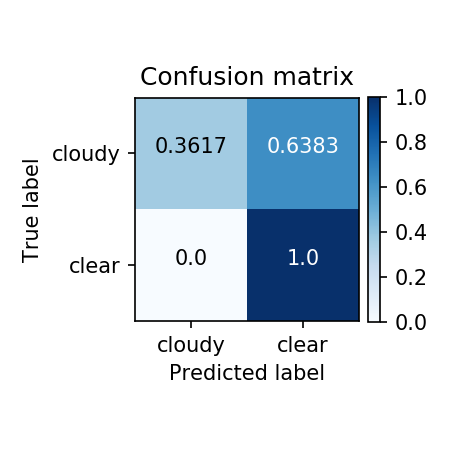

CV scoring: 0.8245 +/ -  0.0007
Test score: 0.8259175508784136


In [19]:
analysis(df[df['location'] == 'la'], tree.DecisionTreeClassifier(max_depth=5), columns)

<IPython.core.display.Javascript object>


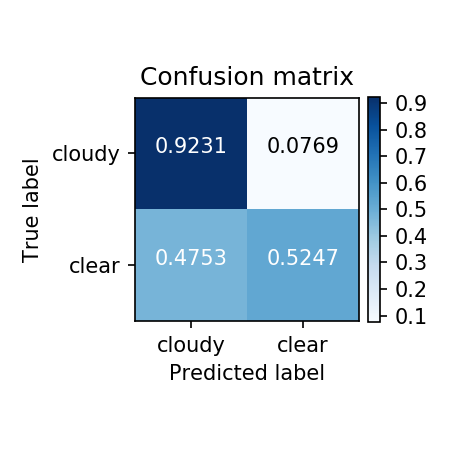

CV scoring: 0.634 +/ -  0.0027
Test score: 0.6287201242045878


In [20]:
analysis(df[df['location'] == 'denver'], tree.DecisionTreeClassifier(max_depth=5), columns)

<IPython.core.display.Javascript object>


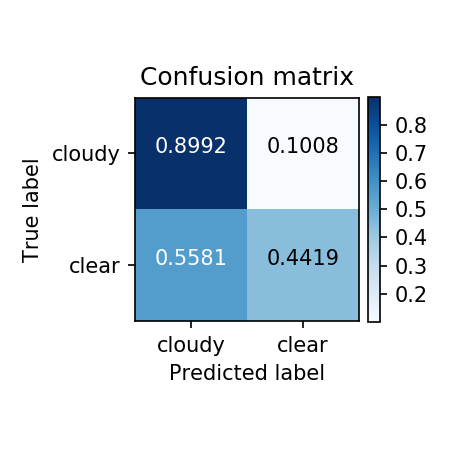

CV scoring: 0.5205 +/ -  0.0027
Test score: 0.5196381053751996


In [21]:
analysis(df[df['location'] == 'nyc'], tree.DecisionTreeClassifier(max_depth=5), columns)

## Random forest

In [ ]:
analysis(df[df['location'] == 'sf'], ensemble.RandomForestClassifier(), columns)

In [ ]:
analysis(df[df['location'] == 'la'], ensemble.RandomForestClassifier(), columns)

In [ ]:
analysis(df[df['location'] == 'denver'], ensemble.RandomForestClassifier(), columns)

In [ ]:
analysis(df[df['location'] == 'nyc'], ensemble.RandomForestClassifier(), columns)

# Cross-location performance

Training models on one location and testing predictive performance at other locations.  Using decision trees since they were the most consistent.

In [ ]:
def make_model(data, clf, columns, loc):
    X = data[data['location'] == loc][columns[:-1]].values
    y = data[data['location'] == loc][columns[-1]].astype(int).values
    clf.fit(X, y)
    return clf

def make_pred(model, data, columns, loc):
    pred = model.predict(data[data['location'] == loc][columns[:-1]].values)
    print('Score: {}'.format(metrics.f1_score(df[df['location'] == loc][columns[-1]].astype(int).values, pred)))
    conf_mat = metrics.confusion_matrix(df[df['location'] == loc][columns[-1]], pred)
    plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])

## Decision tree trained on SF data

In [ ]:
sf_dt = make_model(df, tree.DecisionTreeClassifier(max_depth=5), columns, 'sf')

In [ ]:
make_pred(sf_dt, df, columns, 'sf')

Tests well against itself...

In [ ]:
make_pred(sf_dt, df, columns, 'nyc')

Less accurate versus NYC data.  Different geographic location and climate.

In [ ]:
make_pred(sf_dt, df, columns, 'denver')

Performs reasonably well on Denver data.  More similar climate?  

In [ ]:
make_pred(sf_dt, df, columns, 'la')

## Decision tree trained on NYC data

In [ ]:
nyc_dt = make_model(df, tree.DecisionTreeClassifier(max_depth=5), columns, 'nyc')

In [ ]:
make_pred(nyc_dt, df, columns, 'nyc')

Test well against itself...

In [ ]:
make_pred(nyc_dt, df, columns, 'sf')

Less accurate versus NYC data.  Different geographic location and climate.

In [ ]:
make_pred(nyc_dt, df, columns, 'denver')

Performs reasonably well on Denver data.  More similar climate?  

In [ ]:
make_pred(nyc_dt, df, columns, 'la')

Performs almost as well on LA data as SF data.  Similar locations and climates.

# Train model on all available data

In [ ]:
analysis(df, linear_model.LogisticRegression(), columns)

In [ ]:
analysis(df, tree.DecisionTreeClassifier(max_depth=5), columns)

In [ ]:
analysis(df, ensemble.RandomForestClassifier(max_depth=5), columns)

# Test with rtc data

In [49]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 200] = 0 
    return data

In [50]:
snl_data = load_snl()

In [51]:
snl_data.head()

2015-01-08 22:31:00-07:00    0.0
2015-01-08 22:32:00-07:00    0.0
2015-01-08 22:33:00-07:00    0.0
2015-01-08 22:34:00-07:00    0.0
2015-01-08 22:35:00-07:00    0.0
Freq: T, Name: Global_Wm2, dtype: float64

In [52]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [53]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 
              'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [54]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

In [55]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


In [56]:
snl_df = pd.concat([sample, clear_skies], axis=1)

In [57]:
snl_df.columns = ['GHI', 'Clearsky GHI']

In [58]:
snl_df['Clearsky GHI'] = alpha * snl_df['Clearsky GHI']

In [59]:
snl_df.head()

,GHI,Clearsky GHI
2016-07-01 00:00:00-07:00,0.0,0.0
2016-07-01 00:01:00-07:00,0.0,0.0
2016-07-01 00:02:00-07:00,0.0,0.0
2016-07-01 00:03:00-07:00,0.0,0.0
2016-07-01 00:04:00-07:00,0.0,0.0


In [60]:
snl_df['ratio'] = (snl_df['GHI'] / snl_df['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)
# snl_df['ratio'] = np.abs((snl_df['GHI'] - snl_df['Clearsky GHI']) / snl_df['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)

In [61]:
sf = df[df['location'] == 'la']

X = sf[columns[:-1]].values
y = sf[columns[-1]].astype(int).values
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [62]:
snl_df.as_matrix()

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [63]:
vals = clf.predict(snl_df.as_matrix()).astype(bool)

In [64]:
sf.index

Index([1997-12-31 16:00:00-08:00, 1997-12-31 16:30:00-08:00,
       1997-12-31 17:00:00-08:00, 1997-12-31 17:30:00-08:00,
       1997-12-31 18:00:00-08:00, 1997-12-31 18:30:00-08:00,
       1997-12-31 19:00:00-08:00, 1997-12-31 19:30:00-08:00,
       1997-12-31 20:00:00-08:00, 1997-12-31 20:30:00-08:00,
       ...
       2015-12-31 11:00:00-08:00, 2015-12-31 11:30:00-08:00,
       2015-12-31 12:00:00-08:00, 2015-12-31 12:30:00-08:00,
       2015-12-31 13:00:00-08:00, 2015-12-31 13:30:00-08:00,
       2015-12-31 14:00:00-08:00, 2015-12-31 14:30:00-08:00,
       2015-12-31 15:00:00-08:00, 2015-12-31 15:30:00-08:00],
      dtype='object', length=315360)

<IPython.core.display.Javascript object>


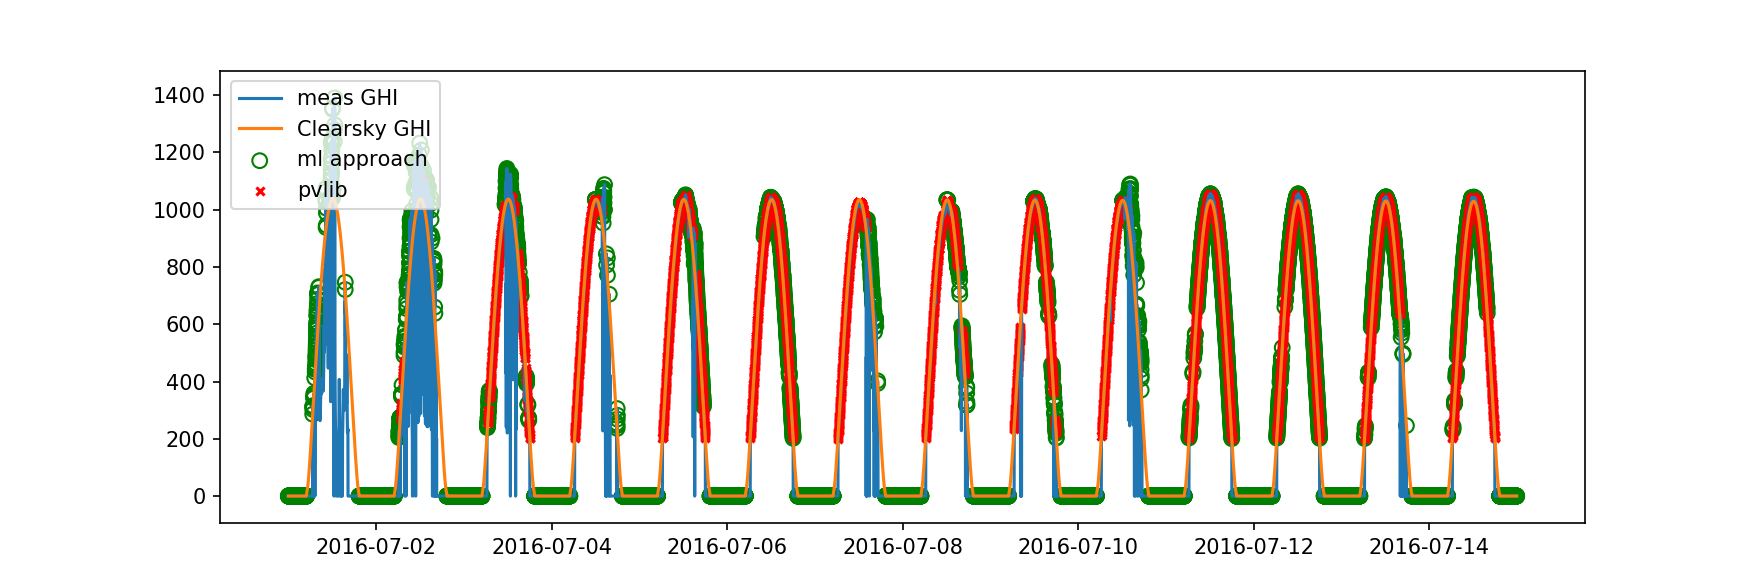

In [262]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(sample.index, sample, label='meas GHI')
ax.plot(snl_df['Clearsky GHI'].index, snl_df['Clearsky GHI'])
ax.scatter(sample[vals].index, sample[vals], edgecolor='green', facecolor='none', s=50, label='ml approach')
ax.scatter(sample[pvlib_clear].index, sample[pvlib_clear], color='red', marker='x', s=15, label='pvlib')
ax.legend()

Using the scaled (by PVLib fitting) model clear sky irradiance misses many periods of clear sky.  It looks as though the ML model is able to identify periods of clear sky as long as the measured irradiance is greater than the modeled irradiance.  It might be worthwhile to use a different metric (percent error?) that is robust to over/undershooting the model curve.  It's also possible to generate the statistical clear sky model for the training data (NSRDB) and use a statistical clear sky model for the predictions as well.

<IPython.core.display.Javascript object>


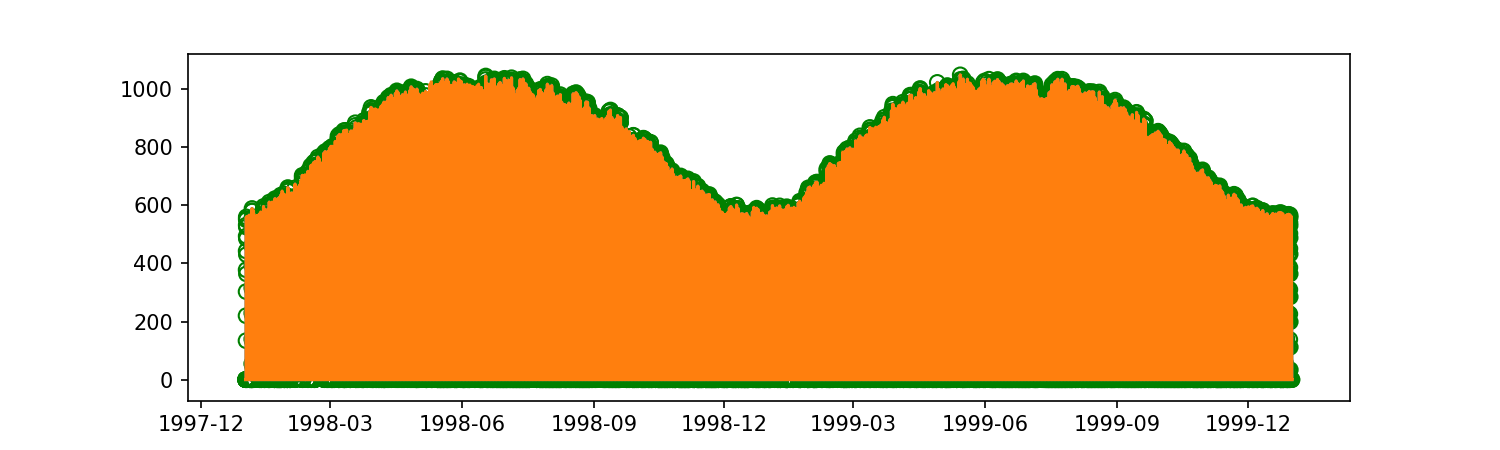

In [228]:
tmp = sf[(sf.index < pd.to_datetime('2000-01-01').tz_localize('US/Pacific')) & (sf.index >= pd.to_datetime('1998-01-01').tz_localize('US/Pacific'))]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(tmp['GHI'].index, tmp['GHI'])
ax.plot(tmp['Clearsky GHI'].index, tmp['Clearsky GHI'])
ax.scatter(tmp[tmp['sky_status'] == 1]['GHI'].index, tmp[tmp['sky_status'] == 1]['GHI'], 
           edgecolor='green', facecolor='none', s=50)

A potential issue is that modeled clearsky irradiance matches measured irradiance 'too well' to provide reliable comparisons to ground data?

In [229]:
import sys
sys.path.append('/Users/benellis/rdtools/model_free/')

In [230]:
import model_free

In [231]:
print(sf.index.to_series().diff().value_counts())
mf = model_free.ModelFreeDetect(tmp['GHI'])

0 days 00:30:00    315355
1 days 00:30:00         4
dtype: int64


In [232]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [233]:
# central_val_ser = pd.Series(central_vals.T.values.ravel(), index=tmp.index).fillna(0)

In [234]:
def rmse(this, that):
    return np.mean(np.sqrt((this - that)**2))

In [238]:
def check_stat_cs(mf, step_size):
    components = mf.deviation_time_filter(model_fxn=np.nanpercentile, percentile=80, 
                                          verbose=True, dev_range=(.8, 1.2), window_size=step_size) 
    central_vals = components['central_vals']
    rmse_val = rmse(central_vals[central_vals > 0], tmp[tmp['Clearsky GHI'] > 0]['Clearsky GHI'])
    return (step_size, rmse_val)

In [239]:
step_list, rmse_list = [], []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(check_stat_cs, mf, i) for i in range(3, 31)]
    for res in concurrent.futures.as_completed(results):
        step_list.append(res.result()[0])
        rmse_list.append(res.result()[1])

/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/benellis/rdtools/model_free/detection_template.py:778: RuntimeWarning: invalid value encountered in true_divide
  deviation_vals = pd.Series(deviation_vals.values / central_vals.values, index=ser_filter.index)
/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/benellis/rdtools/model_free/detection_template.py:778: RuntimeWarning: invalid value encountered in true_divide
  deviation_vals = pd.Series(deviation_vals.values / central_vals.values, index=ser_filter.index)
/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarni

<IPython.core.display.Javascript object>


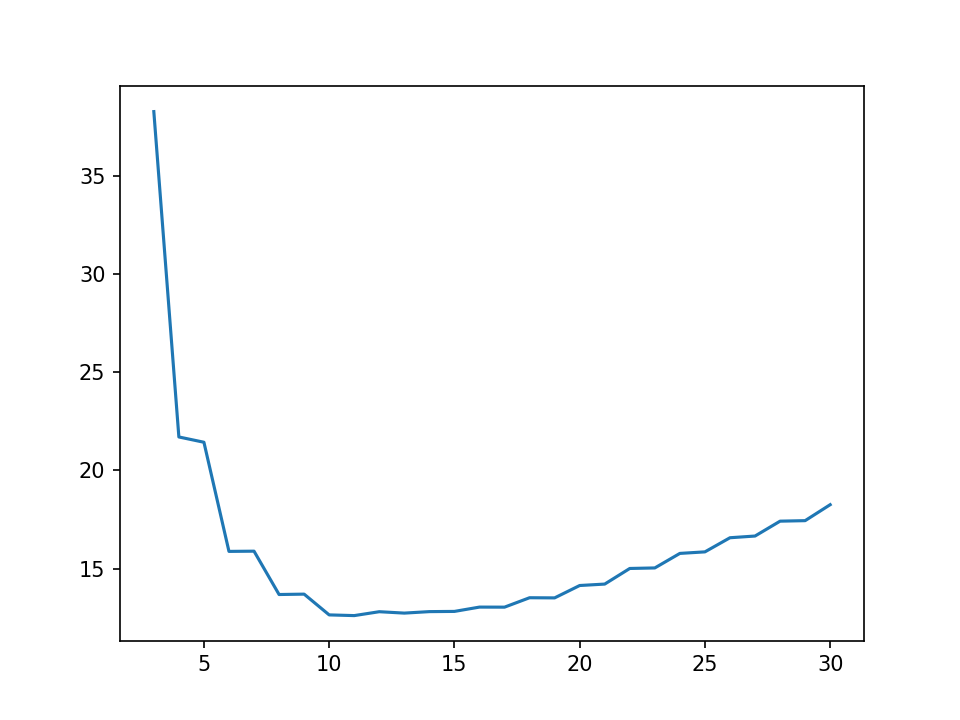

In [240]:
fig, ax = plt.subplots()

ax.plot(step_list, rmse_list)

In [241]:
for i, j in zip(step_list, rmse_list):
    print(i, j)

3 38.2792446292
4 21.7068607069
5 21.4376876877
6 15.8783321783
7 15.8897897898
8 13.6819242319
9 13.7015361515
10 12.6437629938
11 12.6080503581
12 12.806040656
13 12.7350658351
14 12.8107415107
15 12.8212751213
16 13.041037191
17 13.0382074382
18 13.518041118
19 13.5102448602
20 14.1405520906
21 14.2136983137
22 15.0087433587
23 15.0357241857
24 15.7759297759
25 15.8542157542
26 16.5738854239
27 16.6607530608
28 17.4181335181
29 17.4440863941
30 18.2577038577


In [244]:
components = mf.deviation_time_filter(model_fxn=np.nanpercentile, percentile=80, 
                                      verbose=True, dev_range=(.8, 1.2), window_size=21) 
central_vals = components['central_vals']

/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/benellis/rdtools/model_free/detection_template.py:778: RuntimeWarning: invalid value encountered in true_divide
  deviation_vals = pd.Series(deviation_vals.values / central_vals.values, index=ser_filter.index)


<IPython.core.display.Javascript object>


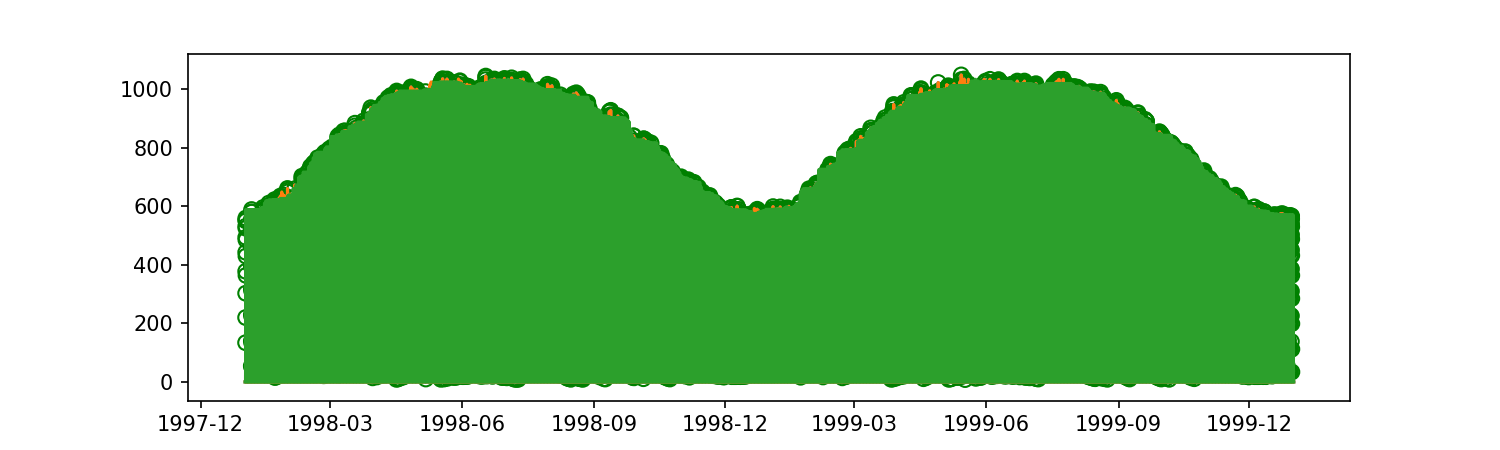

In [245]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(tmp['GHI'].index, tmp['GHI'])
ax.plot(tmp['Clearsky GHI'].index, tmp['Clearsky GHI'])
ax.plot(central_vals.index, central_vals)
ax.scatter(tmp[(tmp['sky_status'] == 1) & (tmp['GHI'] > 0)]['GHI'].index, tmp[(tmp['sky_status'] == 1) & (tmp['GHI'] > 0)]['GHI'], 
           edgecolor='green', facecolor='none', s=50)

In [246]:
tmp['stat cs'] = central_vals

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [247]:
tmp.head()

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,DHI,DNI,Day,Dew Point,Fill Flag,GHI,...,ghi_next,ghi_next_ratio,ghi_pct_error,ghi_ratio,location,min_of_day,sky_status,time,week_of_year,stat cs
1998-01-01 00:00:00-08:00,0,0,0,0,0,0,1,3.859613,0.0,0,...,0.0,0.0,0.0,0.0,la,720.0,True,1998-01-01 00:00:00-08:00,25,0.0
1998-01-01 00:30:00-08:00,0,0,0,0,0,0,1,3.475519,0.0,0,...,0.0,0.0,0.0,0.0,la,690.0,True,1998-01-01 00:30:00-08:00,25,0.0
1998-01-01 01:00:00-08:00,0,0,0,0,0,0,1,3.082086,0.0,0,...,0.0,0.0,0.0,0.0,la,660.0,True,1998-01-01 01:00:00-08:00,25,0.0
1998-01-01 01:30:00-08:00,0,0,0,0,0,0,1,2.400232,0.0,0,...,0.0,0.0,0.0,0.0,la,630.0,True,1998-01-01 01:30:00-08:00,25,0.0
1998-01-01 02:00:00-08:00,0,0,0,0,0,0,1,1.688501,0.0,0,...,0.0,0.0,0.0,0.0,la,600.0,True,1998-01-01 02:00:00-08:00,25,0.0


In [251]:
tmp['cs_ratio'] = (tmp['GHI'] / tmp['Clearsky GHI']).replace(np.nan, 0)

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [252]:
tmp['stat_cs_ratio'] = (tmp['GHI'] / tmp['stat cs']).replace(np.nan, 0)

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [253]:
tmp.head()

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,DHI,DNI,Day,Dew Point,Fill Flag,GHI,...,ghi_pct_error,ghi_ratio,location,min_of_day,sky_status,time,week_of_year,stat cs,cs_ratio,stat_cs_ratio
1998-01-01 00:00:00-08:00,0,0,0,0,0,0,1,3.859613,0.0,0,...,0.0,0.0,la,720.0,True,1998-01-01 00:00:00-08:00,25,0.0,0.0,0.0
1998-01-01 00:30:00-08:00,0,0,0,0,0,0,1,3.475519,0.0,0,...,0.0,0.0,la,690.0,True,1998-01-01 00:30:00-08:00,25,0.0,0.0,0.0
1998-01-01 01:00:00-08:00,0,0,0,0,0,0,1,3.082086,0.0,0,...,0.0,0.0,la,660.0,True,1998-01-01 01:00:00-08:00,25,0.0,0.0,0.0
1998-01-01 01:30:00-08:00,0,0,0,0,0,0,1,2.400232,0.0,0,...,0.0,0.0,la,630.0,True,1998-01-01 01:30:00-08:00,25,0.0,0.0,0.0
1998-01-01 02:00:00-08:00,0,0,0,0,0,0,1,1.688501,0.0,0,...,0.0,0.0,la,600.0,True,1998-01-01 02:00:00-08:00,25,0.0,0.0,0.0


In [255]:
columns = ['GHI', 'cs_ratio', 'sky_status']

X = tmp[columns[:-1]].values
y = tmp[columns[-1]].astype(int).values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.720776255708


In [256]:
columns = ['GHI', 'stat_cs_ratio', 'sky_status']

X = tmp[columns[:-1]].values
y = tmp[columns[-1]].astype(int).values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.709703196347


In [257]:
mf = model_free.ModelFreeDetect(df[df['location'] == 'sf']['GHI'])

In [258]:
components = mf.deviation_time_filter(model_fxn=np.nanpercentile, percentile=80, 
                                      verbose=True, dev_range=(.8, 1.2), window_size=21) 
central_vals = components['central_vals']

/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/benellis/rdtools/model_free/detection_template.py:778: RuntimeWarning: invalid value encountered in true_divide
  deviation_vals = pd.Series(deviation_vals.values / central_vals.values, index=ser_filter.index)


KeyboardInterrupt: 